# Preparation

In [1]:
!pip3 install pandas
!pip3 install matplotlib

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import namedtuple

#plt.style.use('seaborn-white')

In [ ]:
# helper functions

style_ = namedtuple("style_", ["color", "marker", "linestyle"])

def load_csv_files(csv_files):
  dfs = {}
  for key, fname in csv_files.items():
    df = pd.read_csv(fname)
  return dfs

def filter_bench(dfs, query, separator=' '):
  out = {}
  if isinstance(dfs, dict):
    for dkey in dfs.keys():
      if isinstance(query, dict):
        for qkey in query.keys():
          out[dkey + separator + qkey] = dfs[dkey].query(query[qkey])
      else:
        out[dkey] = dfs[dkey].query(query)
  else:
    if isinstance(query, dict):
      for qkey in query:
        out[qkey] = dfs.query(query[qkey])
    else:
      out = dfs.query(query)
  return out

def compare_bench(dfs, reference, match, label="Speedup", target="GPU Time (sec)"):
    def compare_df(df, reference, match, label, target):
      merged = df.merge(reference, on=match, suffixes=('_df', '_ref'), copy=True)
      merged[label] = merged[target + '_ref'] / merged[target + '_df']
      print(merged.head())
      #match.append(label)
      return merged

    if isinstance(dfs, dict):
      out = {}
      for key in dfs.keys():
        if not dfs[key] is reference:
          out[key] = compare_df(dfs[key], reference, match, label, target)
      return out
    else:    
      return compare_df(dfs, reference, match, label, target)

def plot_bench(dfs, xlabel, ylabel, styles=None, show_legend=True, title=None, ofname=None, show_xlabel=True, show_ylabel=True, log_xscale=False, log_yscale=False, font_size=14):
    fig, ax = plt.subplots(1, 1)

    ax.tick_params(labelsize=font_size)
    if(show_ylabel):
        ax.set_xlabel(xlabel, fontsize=font_size)
    if(show_ylabel):
        ax.set_ylabel(ylabel, fontsize=font_size)
    if(log_xscale):
        ax.set_xscale('log')
    if(log_yscale):
        ax.set_yscale('log')
    ax.set_title(title, fontsize=font_size)
    ax.grid()

    for key, df in dfs.items():
        Y = df[ylabel]
        
        if xlabel in df.columns:
            X = df[xlabel]
    
            if isinstance(styles, dict):
              ax.plot(X, Y, label=key, color=styles[key].color, marker=styles[key].marker, linestyle=styles[key].linestyle)
              ax.scatter(X, Y, color=styles[key].color, marker=styles[key].marker, linestyle=styles[key].linestyle)
            else:
              ax.plot(X, Y)
              ax.scatter(X, Y)
        else:
            if isinstance(styles, dict):
              ax.axhline(y=Y.iloc[0], label=key, color=styles[key].color, linestyle=styles[key].linestyle)
            else:
              ax.axhline(y=Y.iloc[0], label=key)

    if(show_legend):
        ax.legend(dfs.keys(), fontsize=font_size - 4)

    if(ofname):
        plt.savefig(ofname, dpi=1200, format='png', bbox_inches='tight')

    plt.show()

In [ ]:
def plot_fpr(filter_size_mb):
    raw = pd.read_csv('../results/bloom_filter_fpr.csv')
    raw = raw.query('Benchmark == "cuco_bloom_filter_fpr" and SlotType == "U32" and Skipped == "No" and FilterSizeMB == @filter_size_mb')
    dfs = filter_bench(raw, {
        'k=1' : 'NumHashes == 1',
        'k=2' : 'NumHashes == 2',
        'k=4' : 'NumHashes == 4',
        'k=6' : 'NumHashes == 6',
        'k=8' : 'NumHashes == 8'})

    styles = {
        'k=1' : style_('b', 'x', '-'),
        'k=2' : style_('r', 'x', '-'),
        'k=4' : style_('g', 'x', '-'),
        'k=6' : style_('c', 'x', '-'),
        'k=8' : style_('k', 'x', '-')}

    plot_bench(dfs, "NumInputs", "FPR", styles=styles)
    plot_bench(filter_bench(dfs, 'NumInputs < 200000000'), "NumInputs", "FPR", styles=styles)

for mb in [37, 43, 50]:
    print("Filter size: " + str(mb) + "MB")
    plot_fpr(mb)

===Performance of small cached (L2 resident) bloom filter===
-INSERT
--L2 hit ratio
---Elems/sec


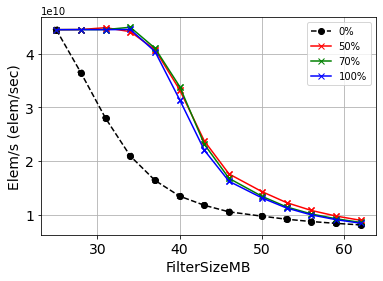

---Speedup (vs. 0%, i.e., no explicit L2 residency control)


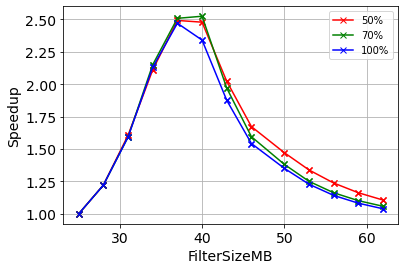

-CONTAINS
--L2 hit ratio
---Elems/sec


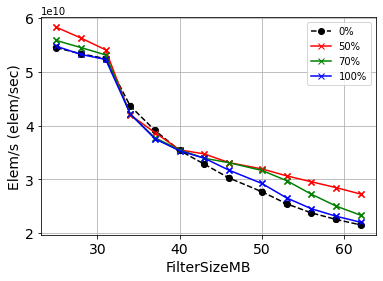

---Speedup (vs. 0%, i.e., no explicit L2 residency control)


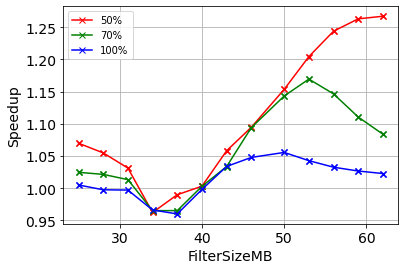

In [88]:
print("===Performance of small cached (L2 resident) bloom filter===")
raw = pd.read_csv('../results/cached_bloom_filter.csv')
raw.query('Skipped == "No"', inplace=True)

def plot_l2_hit_ratio(df):
    print("--L2 hit ratio")

    styles = {
        '0%' : style_('k', 'o', '--'),
        '50%' : style_('r', 'x', '-'),
        '70%' : style_('g', 'x', '-'),
        '100%' : style_('b', 'x', '-')}

    dfs = filter_bench(df, {
        "0%" : 'L2HitRatio == 0',
        "50%" : 'L2HitRatio == 0.5',
        "70%" : 'L2HitRatio == 0.7',
        "100%" : 'L2HitRatio == 1.0'})
    print("---Elems/sec")
    plot_bench(dfs, 'FilterSizeMB', 'Elem/s (elem/sec)', styles=styles)
    print("---Speedup (vs. 0%, i.e., no explicit L2 residency control)")
    plot_bench(compare_bench(dfs, dfs['0%'], match=["KeyType", "NumBits", "FilterSizeMB", "Operation", "NumInputs", "NumHashes"]), "FilterSizeMB", "Speedup", styles=styles)

print("-INSERT")
plot_l2_hit_ratio(raw.query('Operation == "INSERT" and NumInputs == 1000000000'))

print("-CONTAINS")
plot_l2_hit_ratio(raw.query('Operation == "CONTAINS" and NumInputs == 1000000000'))

In [4]:
def plot_access_prop(op):
    raw = pd.read_csv('../results/bloom_filter_access_prop.csv')
    raw = raw.query('Benchmark == "cuco_bloom_filter_access_prop" and NumInputs == 1000000000 and SlotType == "U64" and NumHashes == 1 and Skipped == "No"')

    dfs = {}
    dfs['GMEM'] = raw.query('AccessProperty == "cuda::__4::access_property::normal" and Operation == @op') 
    dfs['L2']   = raw.query('AccessProperty == "cuda::__4::access_property::persisting" and Operation == @op') 

    styles = {
        'GMEM' : style_('b', 'x', '-'),
        'L2' : style_('r', 'x', '-')}

    plot(dfs, "FilterSizeMB", "Elem/s (elem/sec)", styles=styles)
    speedup = {}
    speedup = compare(dfs, dfs['GMEM'], match=["KeyType", "SlotType", "Operation", "FilterSizeMB", "NumInputs", "NumBits", "NumHashes", "Skipped"], label="Speedup")
    plot(speedup, "FilterSizeMB", "Speedup")
    plot(filter(speedup, 'FilterSizeMB < 60'), "FilterSizeMB", "Speedup")

for op in ["INSERT", "CONTAINS"]:
    print("Operation: " + op)
    plot_access_prop(op)


Operation: INSERT


NameError: name 'plot' is not defined

INSERT/CONTAINS on V100/A100 (GMEM)


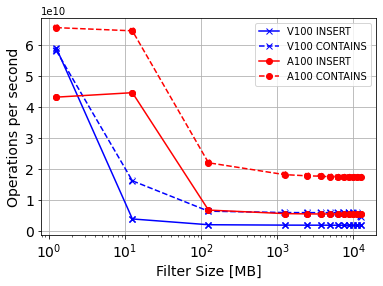

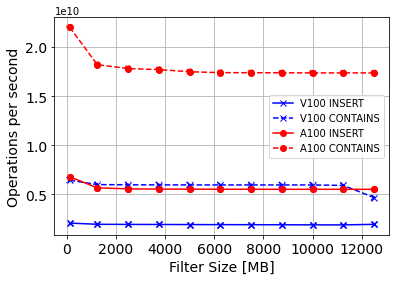

In [8]:
# GMEM
dfs = load_csv_files({"V100" : "../results/bloom_filter_v100.csv", 
                      "A100" : "../results/bloom_filter_a100.csv"})
                          
dfs["V100"]["Filter Size [MB]"] = dfs["V100"]["NumBits"] / 8 / 1000 / 1000
dfs["A100"]["Filter Size [MB]"] = dfs["A100"]["NumBits"] / 8 / 1000 / 1000

dfs["V100 INSERT"] = dfs["V100"].query('Operation == "INSERT"')
dfs["V100 CONTAINS"] = dfs["V100"].query('Operation == "CONTAINS"')
dfs["A100 INSERT"] = dfs["A100"].query('Operation == "INSERT"')
dfs["A100 CONTAINS"] = dfs["A100"].query('Operation == "CONTAINS"')
del dfs["V100"]
del dfs["A100"]

styles = {
    "V100 INSERT" : style_('b', 'x', '-'),
    "V100 CONTAINS" : style_('b', 'x', '--'),
    "A100 INSERT" : style_('r', 'o', '-'),
    "A100 CONTAINS" : style_('r', 'o', '--')}

query = 'Skipped   == "No" and\
         KeyType   == "I32" and\
         SlotType  == "I32" and\
         NumHashes == 2 and\
         NumInputs == 1000000000'

print("INSERT/CONTAINS on V100/A100 (GMEM)")
plot_bench(filter_bench(dfs, query), "Filter Size [MB]", styles=styles, log_xscale=True)

query = query + ' and NumBits > 100000000'
plot_bench(filter_bench(dfs, query), "Filter Size [MB]", styles=styles)

INSERT on A100 (GMEM vs. L2)


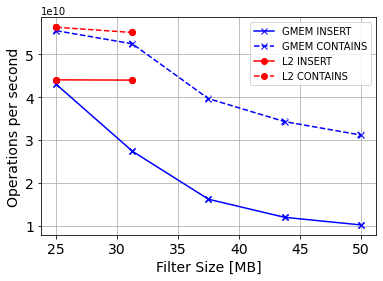

In [9]:
# GMEM vs. L2
df = pd.read_csv("../results/bloom_filter_scope_hit_ratio_60.csv")
df = df[df["Skipped"] == "No"]
df["Filter Size [MB]"] = df["NumBits"] / 8 / 1000 / 1000

dfs = {}
dfs["GMEM INSERT"] = df.query('Scope == "GMEM" and Operation == "INSERT"')
dfs["GMEM CONTAINS"] = df.query('Scope == "GMEM" and Operation == "CONTAINS"')
dfs["L2 INSERT"] = df.query('Scope == "L2" and Operation == "INSERT"')
dfs["L2 CONTAINS"] = df.query('Scope == "L2" and Operation == "CONTAINS"')

styles = {
    "GMEM INSERT" : style_('b', 'x', '-'),
    "GMEM CONTAINS" : style_('b', 'x', '--'),
    "L2 INSERT" : style_('r', 'o', '-'),
    "L2 CONTAINS" : style_('r', 'o', '--')}
    
query = 'KeyType   == "I32" and\
         SlotType  == "I32" and\
         NumHashes == 2 and\
         NumInputs == 50000000'

print("INSERT on A100 (GMEM vs. L2)")
plot_bench(filter_bench(dfs, query), "Filter Size [MB]", styles=styles)